In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score
#from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from sklearn.utils import class_weight

In [33]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [34]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/img1.png')
    plt.show()
    
    return conf_matx

In [35]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/img2.png')
    plt.show()
   
    
    return fig

In [36]:
def loadImages():

    image_list = []
    

    for filename in sorted(glob.glob('/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/Cropped_P276_Conc_170/*.tiff'), key=natural_keys): 
        im=cv2.imread(filename)
        imarray = np.array(im)
        #imarray = imarray.astype('float32')
        image_list.append(imarray)

    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))
    
    path = '/home/jovyan/DATA_MASTER_PROJECT/leb_P276_conc_170_.csv'     
    labels = pd.read_csv(path, usecols=["Type", "Category"],
                       sep="," )
    y_orig = np.array(labels['Category'])

    return x_orig, y_orig

In [37]:
def normalization(data, norm_mean):#, norm_sigma):
    
    x_scaled = (data - norm_mean)# / norm_sigma
    data = x_scaled
    
    return data

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

In [39]:
pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(90, 90, 3))

base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

In [40]:
x_orig_1, y_orig_1 = tqdm.tqdm(loadImages())
x_orig_1.shape, y_orig_1.shape

100%|██████████| 2/2 [00:00<00:00, 6853.44it/s]


((14252, 90, 90, 3), (14252,))

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x_orig_1, y_orig_1, test_size=0.2, random_state=999 )
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((11401, 90, 90, 3), (2851, 90, 90, 3), (11401,), (2851,))

In [42]:
x_train_1, x_val, y_train_1, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=999 )
x_train_1.shape, x_val.shape, y_train_1.shape, y_val.shape

((9120, 90, 90, 3), (2281, 90, 90, 3), (9120,), (2281,))

In [43]:
unique, counts = np.unique(y_train_1, return_counts=True)
dict(zip(unique, counts))

{0: 1212, 1: 1601, 2: 2113, 3: 1771, 4: 2423}

In [44]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 318, 1: 402, 2: 553, 3: 424, 4: 584}

In [45]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train_1),y_train_1)
print('weights = ' + str(weights))

weights = [1.5049505  1.13928795 0.86322764 1.0299266  0.7527858 ]


In [46]:
y_train_1 = keras.utils.to_categorical(y_train_1)
y_test_1 = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

y_train_1.shape, y_test_1.shape, y_val.shape

((9120, 5), (2851, 5), (2281, 5))

In [47]:
print('Shape:{0}\nMean:{1}\nSigma:{2}'.format(x_train_1.shape,np.mean(x_train_1),np.std(x_train_1)))

Shape:(9120, 90, 90, 3)
Mean:22.668270481373185
Sigma:16.385280958654533


In [48]:
norm_mean = np.mean(x_train_1)
norm_sigma = np.std(x_train_1)

x_train_1 = normalization(x_train_1, norm_mean)#, norm_sigma)

x_val = normalization(x_val, norm_mean)#, norm_sigma)

x_test = normalization(x_test, norm_mean)#, norm_sigma)


In [49]:
batch_size = 32

In [50]:
datagen = ImageDataGenerator()

datagen.fit(x_train_1)

train_gen = datagen.flow(x_train_1, y_train_1, batch_size=batch_size)

In [51]:
dat_val = ImageDataGenerator()

dat_val.fit(x_val)

val_gen = dat_val.flow(x_val, y_val, batch_size=batch_size)

In [52]:
m4 = Sequential()
m4.add(base_model)


m4.add(BatchNormalization())
m4.add(GlobalAveragePooling2D())
m4.add(Dense(5, activation = 'softmax'))

m4.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 11, 11, 256)       1735488   
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 1,737,797
Trainable params: 1,737,285
Non-trainable params: 512
_________________________________________________________________


In [53]:
base_model.trainable = False

opt = keras.optimizers.Adam(lr=1e-2)

m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])


In [54]:

epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 285.0 steps, validate for 71.28125 steps
Epoch 1/100
285/285 [==============================] - 6s 21ms/step - loss: 1.2879 - accuracy: 0.4581 - val_loss: 1.2931 - val_accuracy: 0.4910
Epoch 2/100
285/285 [==============================] - 5s 17ms/step - loss: 1.1977 - accuracy: 0.5156 - val_loss: 1.2081 - val_accuracy: 0.5103
Epoch 3/100
285/285 [==============================] - 5s 18ms/step - loss: 1.1626 - accuracy: 0.5319 - val_loss: 1.1659 - val_accuracy: 0.5344
Epoch 4/100
285/285 [==============================] - 5s 17ms/step - loss: 1.1460 - accuracy: 0.5437 - val_loss: 1.1479 - val_accuracy: 0.5502
Epoch 5/100
285/285 [==============================] - 5s 18ms/step - loss: 1.1389 - accuracy: 0.5437 - val_loss: 1.1727 - val_accuracy: 0.5243
Epoch 6/100
285/285 [==============================] - 5s 18ms/step - loss: 1.1252 - accuracy: 0.5542 - val_loss: 1.1560 - val_accuracy: 0.5449
Epoch 7/100
285/285 [==============

In [55]:
base_model.trainable = True

opt = keras.optimizers.Adam(lr=1e-5)

m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])

In [56]:

epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 285.0 steps, validate for 71.28125 steps
Epoch 1/100
285/285 [==============================] - 12s 42ms/step - loss: 1.0512 - accuracy: 0.5947 - val_loss: 1.1758 - val_accuracy: 0.5265
Epoch 2/100
285/285 [==============================] - 11s 39ms/step - loss: 0.9648 - accuracy: 0.6338 - val_loss: 1.0057 - val_accuracy: 0.6111
Epoch 3/100
285/285 [==============================] - 11s 39ms/step - loss: 0.9053 - accuracy: 0.6557 - val_loss: 1.0094 - val_accuracy: 0.6256
Epoch 4/100
285/285 [==============================] - 11s 39ms/step - loss: 0.8562 - accuracy: 0.6745 - val_loss: 0.9444 - val_accuracy: 0.6440
Epoch 5/100
285/285 [==============================] - 11s 39ms/step - loss: 0.8139 - accuracy: 0.6974 - val_loss: 0.9547 - val_accuracy: 0.6260
Epoch 6/100
285/285 [==============================] - 11s 38ms/step - loss: 0.7752 - accuracy: 0.7135 - val_loss: 0.8803 - val_accuracy: 0.6673
Epoch 7/100
285/285 [========

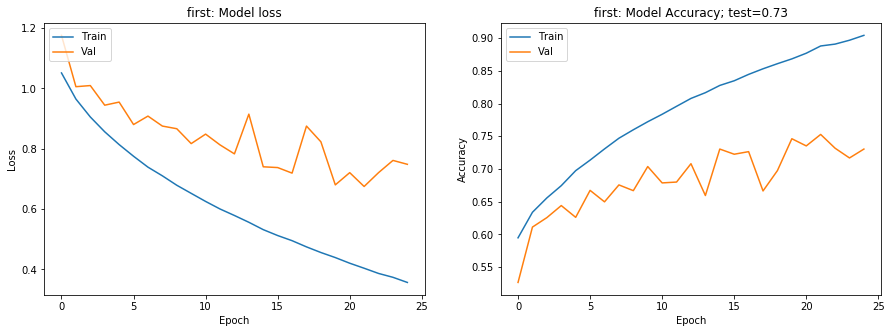

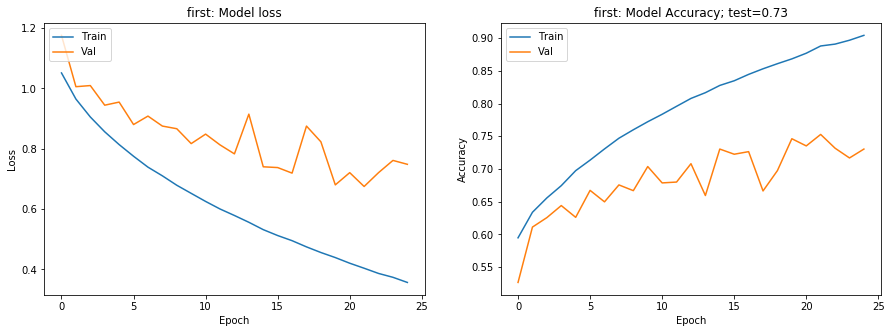

In [57]:
plot_history(m4_h, 'first')


In [58]:
scores = m4.evaluate(x_test, y_test_1)
print("\n%s: %.2f%%" % (m4.metrics_names[1], scores[1]*100))

2851/2851 [==============================] - 1s 462us/sample - loss: 0.7406 - accuracy: 0.7261

accuracy: 72.61%


In [59]:
test_preds = m4.predict(x_test)

In [60]:
preds_df = pd.DataFrame(test_preds)
predicted_labels = preds_df.idxmax(axis=1)

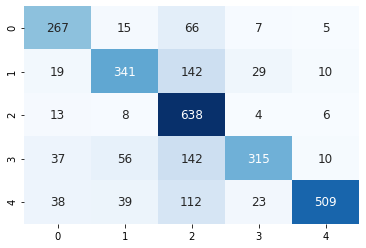

array([[267,  15,  66,   7,   5],
       [ 19, 341, 142,  29,  10],
       [ 13,   8, 638,   4,   6],
       [ 37,  56, 142, 315,  10],
       [ 38,  39, 112,  23, 509]])

In [61]:
draw_confusion_matrix(y_test, predicted_labels)

In [62]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73       360
           1       0.74      0.63      0.68       541
           2       0.58      0.95      0.72       669
           3       0.83      0.56      0.67       560
           4       0.94      0.71      0.81       721

    accuracy                           0.73      2851
   macro avg       0.76      0.72      0.72      2851
weighted avg       0.77      0.73      0.73      2851



In [ ]:
# p = '/home/jovyan/Saved_Models/'
# m4.save(p + "CNN_t1_correct_normaliztion_transfer.h5")